## Задача понижения размерности данных

Что такое изображение?

![img](https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg)

Формально, просто набор чисел, например, картинка сверху - это матрица 500х750:

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

url = 'https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg'

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')
print(np.array(img).shape)
np.array(img)

(500, 750)


array([[145, 145, 144, ..., 142, 143, 144],
       [146, 146, 146, ..., 141, 143, 144],
       [146, 147, 146, ..., 140, 142, 143],
       ...,
       [114, 111, 120, ...,  78,  69,  56],
       [ 75,  83, 104, ...,  53,  51,  64],
       [ 63,  82, 108, ..., 101,  95,  94]], dtype=uint8)

Что если взять случайную точку в пространстве 500*750? Будет ли это какое-то осмысленное изображение? Проверим

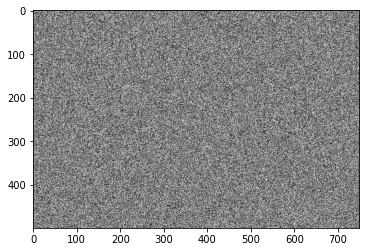

In [3]:
sample_img = np.random.choice(np.arange(256), size=500*750).reshape(500, 750)
plt.imshow(sample_img, cmap='gray')
plt.show()

Вероятно, что осмысленные изображение занимают лишь небольшую долю среди всевозможных числовых матриц? Как описать это подмножество (хотя бы его часть)?

Будем тренироваться строить описание на основе датасете MNIST:

In [4]:
from sklearn.datasets import fetch_openml
digits = fetch_openml('mnist_784')
digits.data.shape

(70000, 784)

In [5]:
images = digits.data.values.reshape(-1, 28, 28)

Пример картинки из датасета:

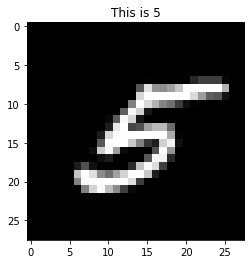

In [6]:
i = 985
plt.imshow(images[i], cmap='gray')
plt.title('This is {}'.format(digits.target[i]))
plt.show()

Воспользуемся моделью PCA:

![img](https://i.stack.imgur.com/G7Gkv.png)

Намопним, PCA ищет подпространство меньшей (но заданной) размерности, проекция на которое максимизирует дисперсию или, что то же самое, минимизирует суммарную ошибку:

![img](http://alexhwilliams.info/itsneuronalblog/img/pca/pca_two_views.png)

Детальное изложение с формулами здесь https://www.csd.uwo.ca/~oveksler/Courses/CS434a_541a/Lecture7.pdf

Пример применение модели PCA (что здесь происходит?):

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

X_transformed = pca.fit_transform(digits.data.astype(float))
X_transformed.shape

(70000, 50)

Дисперсии вдоль главных компонент:

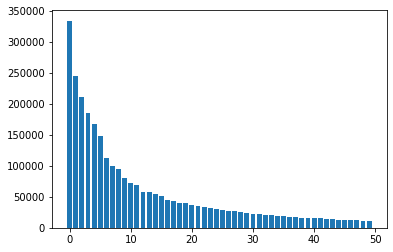

In [8]:
plt.bar(np.arange(50), pca.explained_variance_)
plt.show()

А вот как распределен датасет MNIST в пространстве первых двух главных компонент (разные цвета означают разные цифры на картинках):

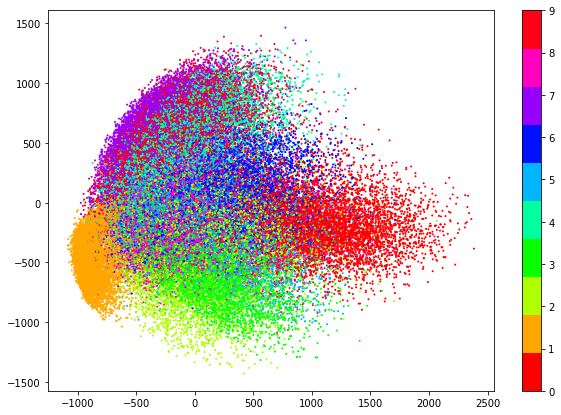

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Разберем, что стоит за операцией transform. Это всего лишь операция проектирования в новый базис:

In [10]:
proj = np.dot(digits.data.astype(float) - pca.mean_, pca.components_.T)
proj.shape

(70000, 50)

И мы получаем ту же самую картинку:

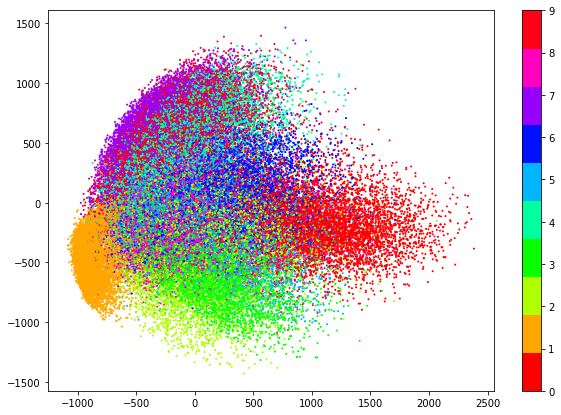

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Картинка в 3D:

In [12]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X_transformed.T[:3], c=digits.target.astype(int), cmap='hsv')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Теперь выполним обратное преобразование:

In [13]:
X_restored = pca.inverse_transform(X_transformed)
X_restored.shape

(70000, 784)

Слева оригинал, справа - изображение, восстановленное из проекции

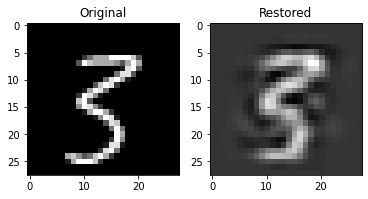

In [14]:
%matplotlib inline
i = 540
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(X_restored[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 1
Выпишите явное линейное преобразование, которое отображает точку из подространства главных компонент в исходное пространство (заполните ??? так, чтобы результат совпал с результатом в предыдущей ячейке)

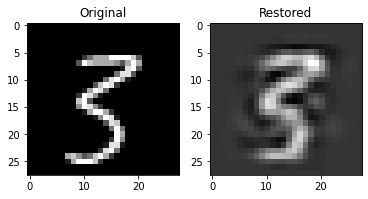

In [15]:
res = np.dot(X_transformed, pca.components_) + pca.mean_

i = 540
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(res[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 2

Определите, сколько нужно взять главных компонент, чтобы объяснить  99%, 95%, 90%, и 85% исходной дисперсии.

### Задача 3

Нарисуйте пример исходного изображения и результат восстановления из числа компонент, которое вы нашли в предыдущей задаче.

![img](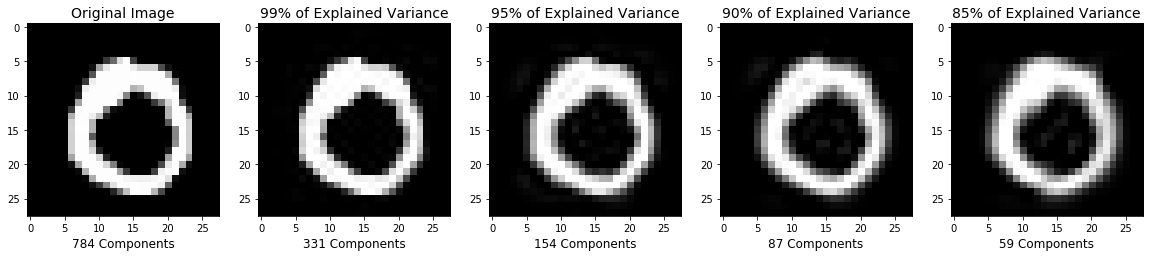%0A)

### Задача 4

Предложите способ генерации новых изображений с числами и приведите примеры сгенерированных картинок.

### Задача 5 (факультатив)
Можно ли построить представления датасета MNIST в 2D с более выраженным разделением кластеров отдельных цифр? For inspiration see https://colah.github.io/posts/2014-10-Visualizing-MNIST/

Задача 2

In [ ]:
def findn(nleft,nright,k):
    if(nright-nleft==1):
        return nright
    n=(nleft+nright)//2
    pcafull=PCA(n_components=n)
    pcafull.fit(digits.data.astype(float))
    if(pcafull.explained_variance_ratio_.sum()<k):
        return findn(n,nright,k)
    else:
        return findn(nleft,n,k)

Задача 3

In [26]:
pca99=PCA(n_components=0.99)
n99 = pca99.fit_transform(digits.data.astype(float))
pca95=PCA(n_components=0.95)
n95 = pca95.fit_transform(digits.data.astype(float))
pca90=PCA(n_components=0.90)
n90 = pca90.fit_transform(digits.data.astype(float))
pca85=PCA(n_components=0.85)
n85 = pca85.fit_transform(digits.data.astype(float))

print("кол-во компонент:",pca99.n_components_,pca95.n_components_,pca90.n_components_,pca85.n_components_)

кол-во компонент: 331 154 87 59


In [ ]:
n99 = pca99.inverse_transform(n99)
n95 = pca95.inverse_transform(n95)
n90 = pca90.inverse_transform(n90)
n85 = pca85.inverse_transform(n85)

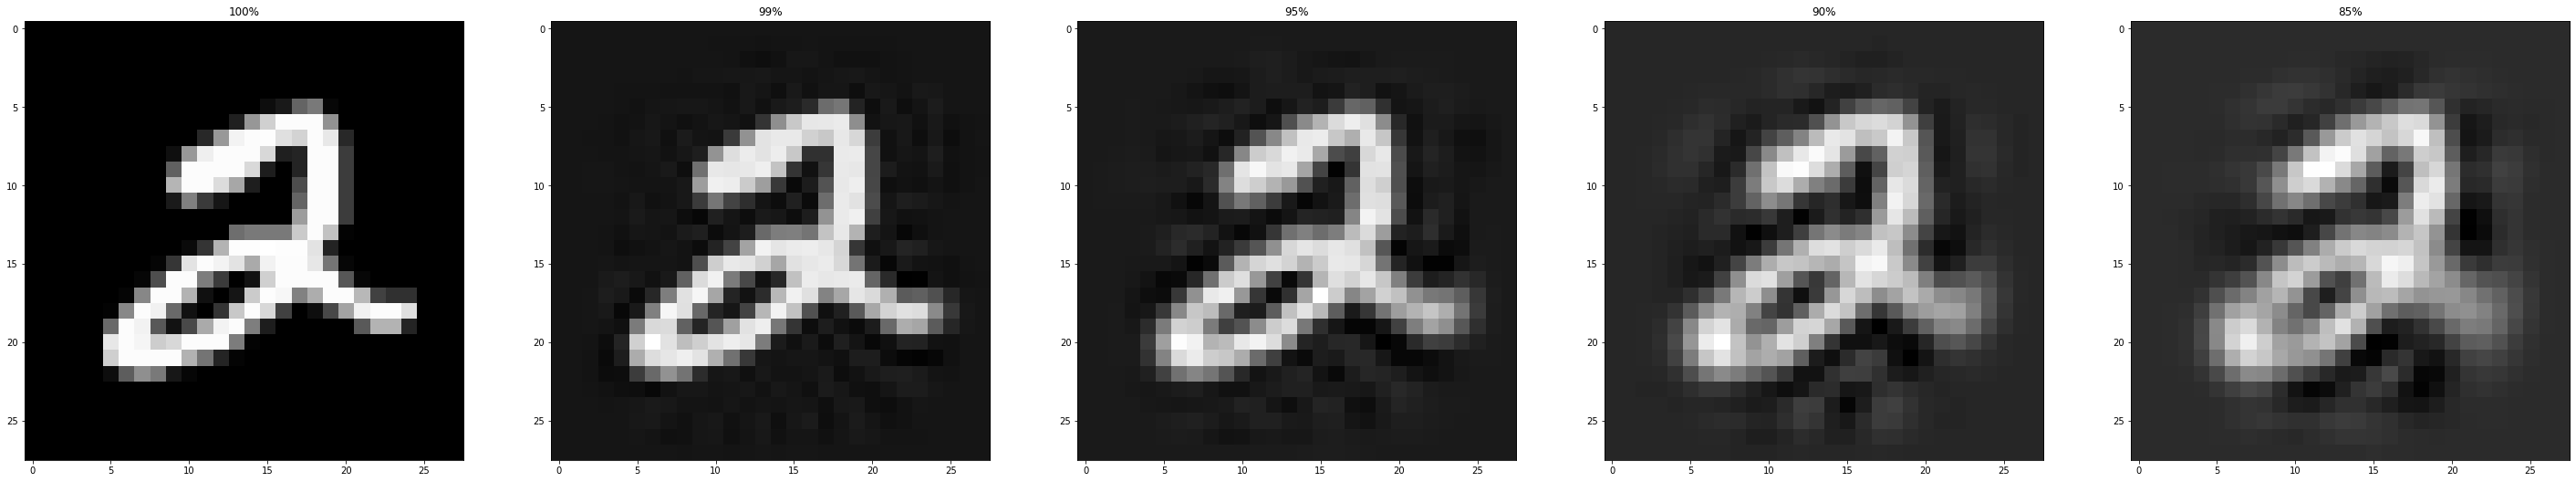

In [39]:
i = 5
fig, ax = plt.subplots(1, 5,figsize=(50,50))
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(n99[i].reshape(28, 28), cmap='gray')
ax[2].imshow(n95[i].reshape(28, 28), cmap='gray')
ax[3].imshow(n90[i].reshape(28, 28), cmap='gray')
ax[4].imshow(n85[i].reshape(28, 28), cmap='gray')
ax[0].set_title('100%')
ax[1].set_title('99%')
ax[2].set_title('95%')
ax[3].set_title('90%')
ax[4].set_title('85%')
plt.show()